<a href="https://colab.research.google.com/github/YunshanDYS/SDS383D_HW_YD/blob/main/GP_SVI_PQloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 361 kB 15.9 MB/s 


In [ ]:
import tqdm
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from math import floor

In [ ]:
# Data 
n = 1000
X1 = torch.normal(0, 1, size=(int(n/2),)) 
X2 = torch.normal(10, 1, size=(int(n/2),)) 
X = torch.cat((X1, X2))

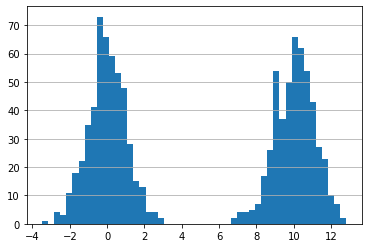

In [ ]:
n_hist, bins, patches = plt.hist(x=X, bins=50)
plt.grid(axis='y')

In [ ]:
from gpytorch.module import Module

class LogLoss(Module):
    def __init__(self, model):
        super(LogLoss, self).__init__()
        self.model = model

    def forward(self, output, **kwargs):
        raise NotImplementedError

In [ ]:
from abc import ABC, abstractmethod

import torch


class _Approximate_loss(LogLoss, ABC):
    # changes here
    def __init__(self, model, num_data, beta=1.0, combine_terms=True):
        super().__init__(model)
        self.combine_terms = combine_terms
        self.num_data = num_data
        self.beta = beta

    @abstractmethod
    def _log_likelihood_term(self, approximate_dist_f, **kwargs):
        raise NotImplementedError

    # changes here, no target
    def forward(self, approximate_dist_f, **kwargs):
        # Get likelihood term and KL term
        num_batch = approximate_dist_f.event_shape[0]
        log_likelihood = self._log_likelihood_term(approximate_dist_f, **kwargs).div(num_batch)
        kl_divergence = self.model.variational_strategy.kl_divergence().div(self.num_data / self.beta)

        # Add any additional registered loss terms
        added_loss = torch.zeros_like(log_likelihood)
        had_added_losses = False
        for added_loss_term in self.model.added_loss_terms():
            added_loss.add_(added_loss_term.loss())
            had_added_losses = True

        # Log prior term
        log_prior = torch.zeros_like(log_likelihood)
        for name, module, prior, closure, _ in self.named_priors():
            log_prior.add_(prior.log_prob(closure(module)).sum().div(self.num_data))

        if self.combine_terms:
            return log_likelihood - kl_divergence + log_prior - added_loss
        else:
            if had_added_losses:
                return log_likelihood, kl_divergence, log_prior, added_loss
            else:
                return log_likelihood, kl_divergence, log_prior

In [ ]:
# Fix mu and alpha for now
mu = torch.Tensor([1, -1])
alpha = 0.2

In [ ]:
# q function
def q_fun(h_samples, mu, alpha):
  q = 1.0 / ((1.0 + (h_samples.unsqueeze(2) - mu)**2 / alpha) + 1e-8)
  q = q**(alpha+1.0)/2.0
  q = q / torch.sum(q, dim=2, keepdim=True)
  return q

In [ ]:
# p function
def p_fun(q):
    p = q**2 / torch.sum(q, dim=1)
    p = p / torch.sum(p, dim=2, keepdim=True)
    return p

In [ ]:
def loss_function(p, q):
    loss = torch.mean(torch.sum(p*torch.log(p/(q+1e-6)), dim=2), dim = 1) 
    return loss

In [ ]:
# check the loss function
h1 = torch.from_numpy(np.repeat(1,(int(n/2),)))
h2 = torch.from_numpy(np.repeat(-1,(int(n/2),)))
h_test = torch.cat((h1, h2)).reshape(1,n)

In [ ]:
q = q_fun(h_test, mu, alpha)
print(q)
p = p_fun(q)
print(p)
loss = loss_function(p,q)
print(loss)

tensor([[[0.9748, 0.0252],
         [0.9748, 0.0252],
         [0.9748, 0.0252],
         ...,
         [0.0252, 0.9748],
         [0.0252, 0.9748],
         [0.0252, 0.9748]]])
tensor([[[9.9933e-01, 6.7047e-04],
         [9.9933e-01, 6.7047e-04],
         [9.9933e-01, 6.7047e-04],
         ...,
         [6.7047e-04, 9.9933e-01],
         [6.7047e-04, 9.9933e-01],
         [6.7047e-04, 9.9933e-01]]])
tensor([0.0225])


In [ ]:
q = q_fun(h_test*0.1, mu, alpha)
print(q)
p = p_fun(q)
print(p)
loss = loss_function(p,q)
print(loss)

tensor([[[0.5988, 0.4012],
         [0.5988, 0.4012],
         [0.5988, 0.4012],
         ...,
         [0.4012, 0.5988],
         [0.4012, 0.5988],
         [0.4012, 0.5988]]])
tensor([[[0.6901, 0.3099],
         [0.6901, 0.3099],
         [0.6901, 0.3099],
         ...,
         [0.3099, 0.6901],
         [0.3099, 0.6901],
         [0.3099, 0.6901]]])
tensor([0.0179])


In [ ]:
rho = np.arange(0, 3, 0.05)
loss = []
for rho_temp in rho:
  h_temp = h_test*rho_temp
  q = q_fun(h_temp, mu, alpha)
  p = p_fun(q)
  loss.append(loss_function(p,q)[0].item())

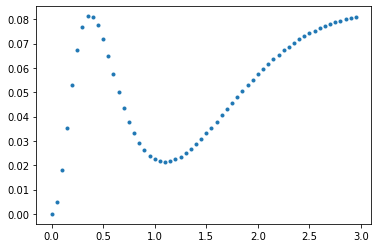

In [ ]:
plt.plot(rho, loss, ".")

In [23]:
q_flat = torch.from_numpy(np.repeat(0.5,(int(n*2),))).reshape(1,n,2)

In [24]:
def loss_function2(p, q):
    loss = torch.mean(torch.sum(p*torch.log(p/(q+1e-6)), dim=2), dim = 1) - torch.mean(torch.sum(p*torch.log(q/(q_flat+1e-6)), dim=2), dim = 1) + 5
    return loss

In [25]:
rho = np.arange(0, 3, 0.05)
loss2 = []
for rho_temp in rho:
  h_temp = h_test*rho_temp
  q = q_fun(h_temp, mu, alpha)
  p = p_fun(q)
  loss2.append(loss_function2(p,q)[0].item())

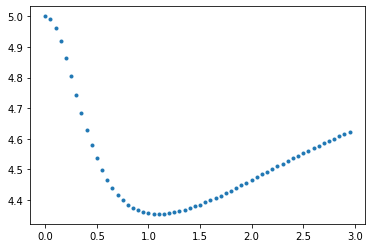

In [27]:
plt.plot(rho, loss2, ".")

In [ ]:
# define the loss function
def expected_log_loss(function_dist, *args, sample_shape=None, **kwargs):
  sample_shape = torch.Size([1000])
  function_samples = function_dist.rsample(sample_shape)
  q = q_fun(function_samples, mu, alpha)
  p = p_fun(q)
  loss_samples = loss_function(p, q)
  log_loss_samples = torch.log(loss_samples)
  return - log_loss_samples.mean(dim=0) 

In [ ]:
class VariationalELBO_loss(_Approximate_loss):
    def _log_likelihood_term(self, variational_dist_f, **kwargs):
        return expected_log_loss(variational_dist_f, **kwargs).sum(-1)

    def forward(self, variational_dist_f, **kwargs):
        return super().forward(variational_dist_f, **kwargs)

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # lengthscale_prior = gpytorch.priors.GammaPrior(100.0, 1.0)
        # outputscale_prior = gpytorch.priors.GammaPrior(50.0, 2)

        # self.covar_module = gpytorch.kernels.ScaleKernel(
        #     gpytorch.kernels.RBFKernel(
        #         lengthscale_prior=lengthscale_prior,
        #     ),
        #     outputscale_prior=outputscale_prior
        # )

        # # Initialize lengthscale and outputscale to mean of priors
        # self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        # self.covar_module.outputscale = outputscale_prior.mean


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = X #[torch.randint(0, n, (int(n/4),))]
model = GPModel(inducing_points=inducing_points)

In [ ]:
num_epochs = 10

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Our loss object. We're using the VariationalELBO
mll = VariationalELBO_loss(model, num_data=X.size(0))

tol = 1e-7
for i in range(num_epochs):
  optimizer.zero_grad()
  output = model(X)
  with torch.no_grad():
    if i > 0:
      loss_old = loss
  loss = mll(output)
  loss.backward()
  optimizer.step()

  if i % 20 == 0:
    print('In epoch {}, loss: {:.4f}'.format(i, loss))
  
  if i > 0:
    if abs((loss_old - loss)/loss_old) < tol:
      print('Converge!')
      break

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In epoch 0, loss: 0.0029


In [ ]:
# import pdb

num_epochs = 100

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Our loss object. We're using the VariationalELBO
mll = VariationalELBO_loss(model, num_data=X.size(0))

tol = 1e-7
for i in range(num_epochs):
  optimizer.zero_grad()
  output = model(X)
  with torch.no_grad():
    if i > 0:
      loss_old = loss
  loss = -mll(output)
  loss.backward()

  # pdb.set_trace()
  optimizer.step()

  if i % 20 == 0:
    print('In epoch {}, loss: {:.4f}'.format(i, loss))
  
  if i > 0:
    if abs((loss_old - loss)/loss_old) < tol:
      print('Converge!')
      break

In epoch 0, loss: 36.4260
In epoch 20, loss: 1.7699
In epoch 40, loss: 0.0312
In epoch 60, loss: 0.0228
In epoch 80, loss: -0.0079


In [ ]:

X_test = torch.Tensor(np.arange(-5, 15, 0.1))
model.eval()
with torch.no_grad():
    preds = model(X_test)
    means = preds.mean
    CI1, CI2 = preds.confidence_region()

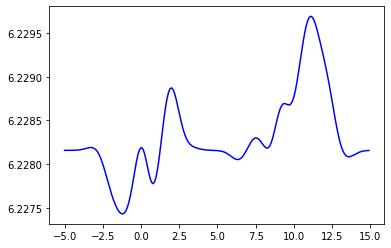

In [ ]:
# Visualize the result
plt.plot(X_test, means, '-', color='blue')
# plt.fill_between(X_test, CI1, CI2, color='blue', alpha=0.2)

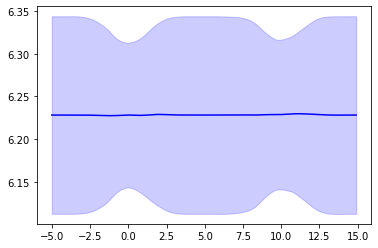

In [ ]:
# Visualize the result
plt.plot(X_test, means, '-', color='blue')
plt.fill_between(X_test, CI1, CI2, color='blue', alpha=0.2)

It doesn't work...

I suspect the reason is that initialization leads to some flat curve and the PQloss is actually quite satisfied with this flat curve. This is similar to the issue I met when I firsted tried SpaGCN. We probably need k means for initialization.

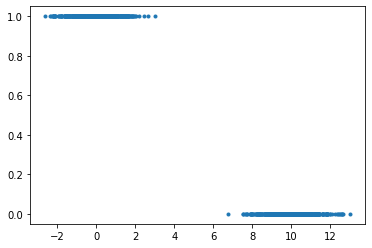

In [ ]:
# k means
from sklearn.cluster import KMeans

k_means = KMeans(init="k-means++", n_clusters=2, n_init=2)
k_means.fit(X.reshape(-1,1))
label_kmeans = k_means.labels_
label_kmeans = torch.from_numpy(label_kmeans).long()

plt.plot(X, label_kmeans, ".")

In [ ]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [ ]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(label_kmeans, learn_additional_noise=True)
model = DirichletGPModel(X, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [ ]:
training_iter = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/100 - Loss: 3.082   lengthscale: 0.693   noise: 0.693
Iter 6/100 - Loss: 2.895   lengthscale: 0.969   noise: 0.474
Iter 11/100 - Loss: 2.761   lengthscale: 1.272   noise: 0.316
Iter 16/100 - Loss: 2.669   lengthscale: 1.570   noise: 0.209
Iter 21/100 - Loss: 2.621   lengthscale: 1.839   noise: 0.140
Iter 26/100 - Loss: 2.542   lengthscale: 2.075   noise: 0.097
Iter 31/100 - Loss: 2.549   lengthscale: 2.278   noise: 0.070
Iter 36/100 - Loss: 2.537   lengthscale: 2.450   noise: 0.053
Iter 41/100 - Loss: 2.516   lengthscale: 2.593   noise: 0.042
Iter 46/100 - Loss: 2.501   lengthscale: 2.721   noise: 0.034
Iter 51/100 - Loss: 2.486   lengthscale: 2.833   noise: 0.029
Iter 56/100 - Loss: 2.472   lengthscale: 2.934   noise: 0.025
Iter 61/100 - Loss: 2.520   lengthscale: 3.024   noise: 0.022
Iter 66/100 - Loss: 2.488   lengthscale: 3.102   noise: 0.019
Iter 71/100 - Loss: 2.483   lengthscale: 3.171   noise: 0.018
Iter 76/100 - Loss: 2.482   lengthscale: 3.234   noise: 0.016
Iter 81/10

In [ ]:
print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale)
print(model.covar_module.base_kernel.lengthscale[0].item())

tensor([[[3.5208]],

        [[3.4811]]], grad_fn=<SoftplusBackward0>)
tensor([3.5451, 3.5532], grad_fn=<SoftplusBackward0>)
3.52077317237854


In [ ]:
X_test = torch.Tensor(np.arange(-5, 15, 0.1))

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(X_test)
    pred_means = test_dist.loc

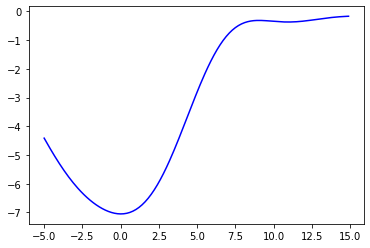

In [ ]:
plt.plot(X_test, pred_means[0], '-', color='blue')

In [ ]:
lengthscale_prior = model.covar_module.base_kernel.lengthscale[0].item()
outputscale_prior = model.covar_module.outputscale[0].item()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
  y_dist = model(X)
  pred_means = y_dist.loc
mu_prior = torch.Tensor([pred_means[0][label_kmeans == 0].mean().item(), pred_means[0][label_kmeans == 1].mean().item()])
print(lengthscale_prior)
print(outputscale_prior)
print(mu_prior)

3.52077317237854
3.545067548751831
tensor([-0.3518, -6.9107])


/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


In [ ]:
from gpytorch.module import Module

class LogLoss(Module):
    def __init__(self, model):
        super(LogLoss, self).__init__()
        self.model = model

    def forward(self, output, **kwargs):
        raise NotImplementedError

In [ ]:
from abc import ABC, abstractmethod

import torch


class _Approximate_loss(LogLoss, ABC):
    # changes here
    def __init__(self, model, num_data, beta=1.0, combine_terms=True):
        super().__init__(model)
        self.combine_terms = combine_terms
        self.num_data = num_data
        self.beta = beta

    @abstractmethod
    def _log_likelihood_term(self, approximate_dist_f, **kwargs):
        raise NotImplementedError

    # changes here, no target
    def forward(self, approximate_dist_f, **kwargs):
        # Get likelihood term and KL term
        num_batch = approximate_dist_f.event_shape[0]
        log_likelihood = self._log_likelihood_term(approximate_dist_f, **kwargs).div(num_batch)
        kl_divergence = self.model.variational_strategy.kl_divergence().div(self.num_data / self.beta)

        # Add any additional registered loss terms
        added_loss = torch.zeros_like(log_likelihood)
        had_added_losses = False
        for added_loss_term in self.model.added_loss_terms():
            added_loss.add_(added_loss_term.loss())
            had_added_losses = True

        # Log prior term
        log_prior = torch.zeros_like(log_likelihood)
        for name, module, prior, closure, _ in self.named_priors():
            log_prior.add_(prior.log_prob(closure(module)).sum().div(self.num_data))

        if self.combine_terms:
            return log_likelihood - kl_divergence + log_prior - added_loss
        else:
            if had_added_losses:
                return log_likelihood, kl_divergence, log_prior, added_loss
            else:
                return log_likelihood, kl_divergence, log_prior

In [ ]:
# Fix mu and alpha for now
mu = mu_prior
alpha = 0.2

In [ ]:
# q function
def q_fun(h_samples, mu, alpha):
  q = 1.0 / ((1.0 + (h_samples.unsqueeze(2) - mu)**2 / alpha) + 1e-8)
  q = q**(alpha+1.0)/2.0
  q = q / torch.sum(q, dim=2, keepdim=True)
  return q

In [ ]:
# p function
def p_fun(q):
    p = q**2 / torch.sum(q, dim=1)
    p = p / torch.sum(p, dim=2, keepdim=True)
    return p

In [ ]:
def loss_function(p, q):
    loss = torch.mean(torch.sum(p*torch.log(p/(q+1e-6)), dim=2), dim = 1) 
    return loss

In [ ]:
# define the loss function
def expected_log_loss(function_dist, *args, sample_shape=None, **kwargs):
  sample_shape = torch.Size([1000])
  function_samples = function_dist.rsample(sample_shape)
  q = q_fun(function_samples, mu, alpha)
  p = p_fun(q)
  loss_samples = loss_function(p, q)
  log_loss_samples = torch.log(loss_samples)
  return log_loss_samples.mean(dim=0) 

In [ ]:
class VariationalELBO_loss(_Approximate_loss):
    def _log_likelihood_term(self, variational_dist_f, **kwargs):
        return expected_log_loss(variational_dist_f, **kwargs).sum(-1)

    def forward(self, variational_dist_f, **kwargs):
        return super().forward(variational_dist_f, **kwargs)

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # lengthscale_prior = gpytorch.priors.GammaPrior(100.0, 1.0)
        # outputscale_prior = gpytorch.priors.GammaPrior(50.0, 2)

        # self.covar_module = gpytorch.kernels.ScaleKernel(
        #     gpytorch.kernels.RBFKernel(
        #         lengthscale_prior=lengthscale_prior,
        #     ),
        #     outputscale_prior=outputscale_prior
        # )

        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior
        self.covar_module.outputscale = outputscale_prior


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = X#[torch.randint(0, n, (int(n/2),))]
model = GPModel(inducing_points=inducing_points)

In [ ]:
X_test = torch.Tensor(np.arange(-5, 15, 0.1))
model.eval()
with torch.no_grad():
    preds = model(X_test)
    means = preds.loc
    CI1, CI2 = preds.confidence_region()

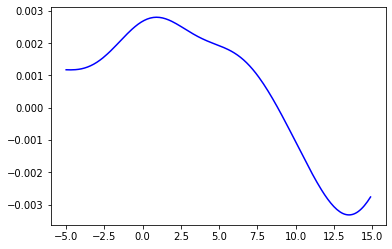

In [ ]:
# Visualize the result
plt.plot(X_test, means, '-', color='blue')

In [ ]:
model.covar_module.base_kernel.lengthscale

tensor([[3.5208]], grad_fn=<SoftplusBackward0>)

In [ ]:
num_epochs = 100

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = VariationalELBO_loss(model, num_data=X.size(0))

tol = 1e-7
for i in range(num_epochs):
  optimizer.zero_grad()
  output = model(X)
  with torch.no_grad():
    if i > 0:
      loss_old = loss
  loss = -mll(output)
  loss.backward()
  optimizer.step()

  if i % 20 == 0:
    print('In epoch {}, loss: {:.4f}'.format(i, loss))
  
  if i > 0:
    if abs((loss_old - loss)/loss_old) < tol:
      print('Converge!')
      break

In epoch 0, loss: 0.0031
In epoch 20, loss: 0.0036
In epoch 40, loss: 0.0031
In epoch 60, loss: 0.0030
In epoch 80, loss: 0.0030


In [ ]:
X_test = torch.Tensor(np.arange(-5, 15, 0.1))
model.eval()
with torch.no_grad():
    preds = model(X_test)
    means = preds.mean
    CI1, CI2 = preds.confidence_region()

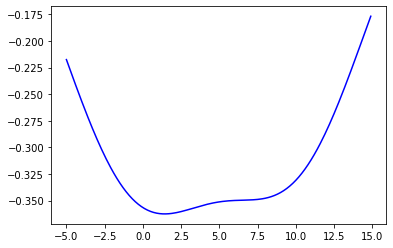

In [ ]:
# Visualize the result
plt.plot(X_test, means, '-', color='blue')
# plt.fill_between(X_test, CI1, CI2, color='blue', alpha=0.2)

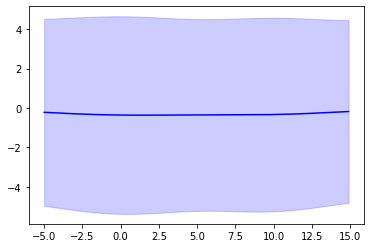

In [ ]:
# Visualize the result
plt.plot(X_test, means, '-', color='blue')
plt.fill_between(X_test, CI1, CI2, color='blue', alpha=0.2)